## Import Library & Load Data

In [41]:
# ==========================================
# TAHAP 1: SETUP & LOAD DATA
# ==========================================

import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Load data yang sudah bersih (dari Notebook 01)
# Pastikan path ini sesuai dengan folder kamu
df = pd.read_csv('../data/processed/players_clean.csv')

print(f"✅ Data Loaded. Total Pemain: {df.shape[0]}")
print("Contoh Posisi Mentah (Sebelum Grouping):")
print(df['player_positions'].head(5).tolist())

✅ Data Loaded. Total Pemain: 41275
Contoh Posisi Mentah (Sebelum Grouping):
['CB, LB', 'LB', 'CB, CDM', 'ST', 'ST']


## Mapping (Pengelompokan Posisi)

In [42]:
# ==========================================
# TAHAP 2: GROUPING POSISI (LABELING)
# ==========================================

def simplify_position(pos_string):
    """
    Mengubah list posisi rumit (misal 'CF, ST') menjadi 1 kategori besar.
    """
    if pd.isna(pos_string):
        return 'Unknown'
        
    # Ambil posisi prioritas (yang pertama ditulis)
    first_pos = pos_string.split(',')[0].strip()
    
    # Kategori 1: ATTACKER (Penyerang)
    if first_pos in ['ST', 'CF', 'LW', 'RW', 'RS', 'LS', 'LF', 'RF']:
        return 'Attacker'
    
    # Kategori 2: MIDFIELDER (Gelandang)
    elif first_pos in ['CAM', 'CM', 'CDM', 'LM', 'RM', 'LAM', 'RAM', 'LCM', 'RCM', 'LDM', 'RDM']:
        return 'Midfielder'
    
    # Kategori 3: DEFENDER (Bek)
    elif first_pos in ['CB', 'LB', 'RB', 'LWB', 'RWB', 'LCB', 'RCB']:
        return 'Defender'
    
    # Kategori 4: GOALKEEPER (Kiper)
    elif first_pos in ['GK']:
        return 'Goalkeeper'
        
    return 'Unknown'

# Terapkan fungsi di atas ke kolom 'player_positions'
df['simple_position'] = df['player_positions'].apply(simplify_position)

# Hapus jika masih ada 'Unknown' atau 'Goalkeeper' (karena kita fokus outfield)
df = df[df['simple_position'] != 'Unknown']
df = df[df['simple_position'] != 'Goalkeeper'] # Opsional, harusnya GK sudah bersih dari tahap 1

print("✅ Grouping Selesai! Berikut sebaran datanya:")
print(df['simple_position'].value_counts())

✅ Grouping Selesai! Berikut sebaran datanya:
simple_position
Midfielder    17070
Defender      15044
Attacker       9161
Name: count, dtype: int64


## Persiapan Training

In [43]:
# ==========================================
# TAHAP 3: SPLIT TRAIN & TEST
# ==========================================

# 1. Tentukan Fitur (Soal Ujian) - HARUS SAMA dengan Model V1
feature_cols = [
    'height_cm', 'weight_kg','pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic',
    'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy',
    'attacking_short_passing', 'attacking_volleys',
    'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing',
    'skill_ball_control',
    'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
    'movement_reactions', 'movement_balance',
    'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength',
    'power_long_shots',
    'mentality_aggression', 'mentality_interceptions', 'mentality_positioning',
    'mentality_vision', 'mentality_penalties', 'mentality_composure',
    'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle'
]

# Pastikan hanya kolom yang ada yang diambil
existing_features = [col for col in feature_cols if col in df.columns]

X = df[existing_features]
y = df['simple_position'] # Target (Label)

# 2. Bagi Data: 80% untuk Belajar, 20% untuk Ujian
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"📚 Data Training: {X_train.shape[0]} pemain")
print(f"📝 Data Testing: {X_test.shape[0]} pemain")

📚 Data Training: 33020 pemain
📝 Data Testing: 8255 pemain


## Training & Evaluasi

In [44]:
# ==========================================
# TAHAP 4: TRAINING RANDOM FOREST
# ==========================================

# Inisialisasi Model
rf_model = RandomForestClassifier(n_estimators=150, random_state=42)

# Latih Model
print("⏳ Sedang melatih model... (Tunggu sebentar)")
rf_model.fit(X_train, y_train)

# Prediksi Data Test
y_pred = rf_model.predict(X_test)

# ==========================================
# TAHAP 5: EVALUASI (LAPORAN AKURASI)
# ==========================================

print("\n🎯 HASIL EVALUASI MODEL V2:")
print("-" * 30)
acc = accuracy_score(y_test, y_pred)
print(f"✅ Accuracy Score: {acc:.2%}")
print("-" * 30)

print("\n📊 Laporan Detail per Posisi:")
print(classification_report(y_test, y_pred))

# Cek Feature Importance (Skill apa yang paling menentukan posisi?)
import matplotlib.pyplot as plt

feat_importances = pd.Series(rf_model.feature_importances_, index=existing_features)
print("\n🔑 Top 5 Skill Paling Pembeda Posisi:")
print(feat_importances.nlargest(5))

⏳ Sedang melatih model... (Tunggu sebentar)

🎯 HASIL EVALUASI MODEL V2:
------------------------------
✅ Accuracy Score: 88.50%
------------------------------

📊 Laporan Detail per Posisi:
              precision    recall  f1-score   support

    Attacker       0.88      0.80      0.84      1832
    Defender       0.93      0.93      0.93      3009
  Midfielder       0.85      0.89      0.87      3414

    accuracy                           0.89      8255
   macro avg       0.89      0.87      0.88      8255
weighted avg       0.89      0.89      0.88      8255


🔑 Top 5 Skill Paling Pembeda Posisi:
defending_sliding_tackle     0.083299
defending                    0.068203
attacking_finishing          0.063749
mentality_vision             0.060121
defending_standing_tackle    0.057765
dtype: float64


## Visualisasi

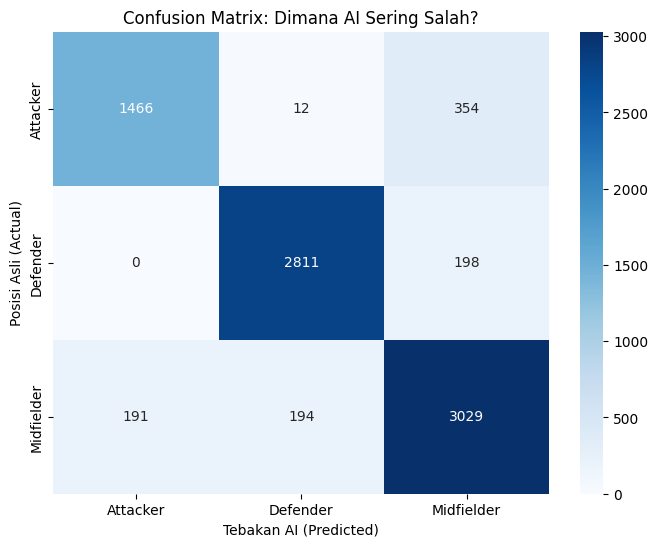

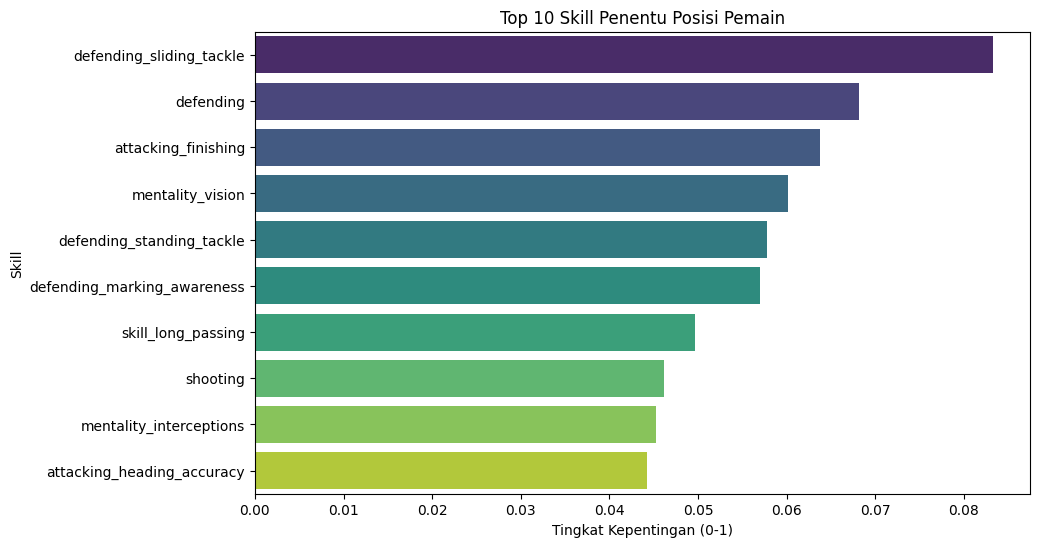

In [45]:
# ==========================================
# VISUALISASI
# ==========================================
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. CONFUSION MATRIX (HEATMAP)
# Ini visualisasi untuk melihat: AI paling sering salah tebak dimana?
# ------------------------------------------------------------------
cm = confusion_matrix(y_test, y_pred)
labels = ['Attacker', 'Defender', 'Midfielder'] # Urutan alfabetis

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix: Dimana AI Sering Salah?')
plt.xlabel('Tebakan AI (Predicted)')
plt.ylabel('Posisi Asli (Actual)')
plt.show()

# Penjelasan Cara Baca:
# Kotak diagonal (Biru Gelap) adalah tebakan BENAR.
# Kotak warna muda di luar diagonal adalah tebakan SALAH.
# Misal: Baris 'Defender', Kolom 'Midfielder' ada angka X -> Berarti ada X Bek yang dikira Gelandang.

# 2. FEATURE IMPORTANCE (BAR CHART)
# Visualisasi skill paling berpengaruh
# ------------------------------------------------------------------
importance_df = pd.DataFrame({
    'Feature': existing_features,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False).head(10) # Ambil Top 10

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, hue='Feature', legend=False, palette='viridis')
plt.title('Top 10 Skill Penentu Posisi Pemain')
plt.xlabel('Tingkat Kepentingan (0-1)')
plt.ylabel('Skill')
plt.show()

## Simpan Model

In [46]:
# ==========================================
# TAHAP 6: SAVE MODEL
# ==========================================

# Simpan Model Random Forest
joblib.dump(rf_model, '../models/rf_classifier.pkl')

# Simpan Dataset yang sudah ada label 'simple_position'-nya
# (Penting: Web butuh kolom ini untuk menampilkan label di hasil pencarian)
df.to_csv('../data/processed/players_labeled.csv', index=False)

print("✅ Model Classifier & Data Labeled berhasil disimpan!")

✅ Model Classifier & Data Labeled berhasil disimpan!
